In [1]:
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
pwd

'/drive4/Anshuman/testing_project/vahadane'

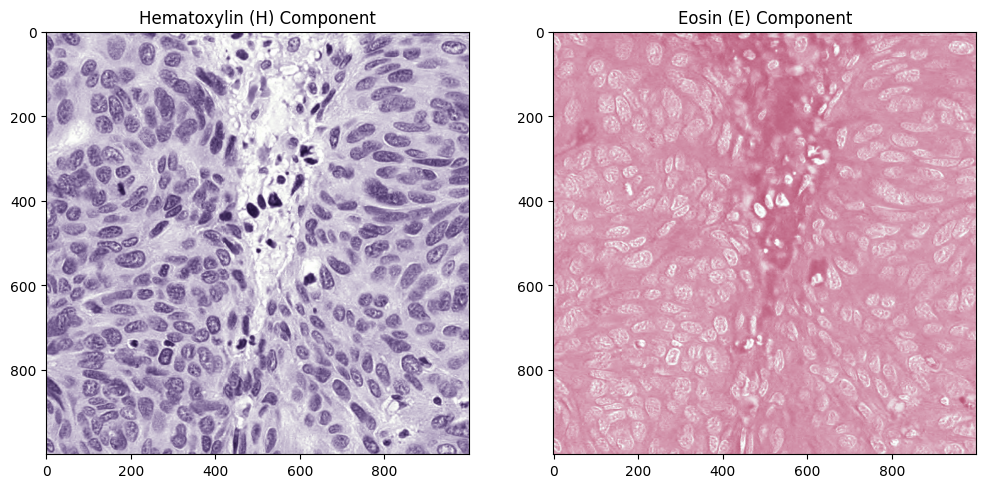

In [4]:



def normalizeStaining(img, saveFile=None, Io=240, alpha=1, beta=0.15):
    ''' Normalize staining appearence of H&E stained images
    
    Example use:
        see test.py
        
    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity
        
    Output:
        Inorm: normalized image
        H: hematoxylin image
        E: eosin image
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    maxCRef = np.array([1.9705, 1.0308])
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    img = img.reshape((-1,3))

    # calculate optical density
    OD = -np.log((img.astype(float)+1)/Io)
    
    # remove transparent pixels
    ODhat = OD[~np.any(OD<beta, axis=1)]
        
    # compute eigenvectors
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    #eigvecs *= -1
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # unmix hematoxylin and eosin
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    if saveFile is not None:
        Image.fromarray(Inorm).save(saveFile+'.png')
        Image.fromarray(H).save(saveFile+'_H.png')
        Image.fromarray(E).save(saveFile+'_E.png')

    return Inorm, H, E

if __name__ == '__main__':
    # Define the argument values explicitly
    imageFile = "/drive4/Anshuman/testing_project/vahadane/TCGA-18-5592-01Z-00-DX1.tif"
    saveFile = "output"
    Io = 240
    alpha = 1
    beta = 0.15

    # Call the normalizeStaining function directly with the defined arguments
    normalized_img, H, E = normalizeStaining(
        img=np.array(Image.open(imageFile)),
        saveFile=saveFile,
        Io=Io,
        alpha=alpha,
        beta=beta
    )

    # Display the H and E component images using Matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(H)
    plt.title('Hematoxylin (H) Component')

    plt.subplot(1, 2, 2)
    plt.imshow(E)
    plt.title('Eosin (E) Component')
    plt.show()

In [5]:
#CAIB_WSI/CAIB/CAIB-T00000420OC/CAIB-T00000420OC01R01/CAIB-T00000420OC01R01R0809HE/CAIB-T00000420OC01R01R0809HE